In [22]:
#VGG 19 Model and results

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import urllib
import io
import skimage.transform
from gen_adver import FastGradient

import lasagne
from lasagne.layers import InputLayer, DenseLayer, DropoutLayer
from lasagne.layers.conv import Conv2DLayer as ConvLayer
from lasagne.layers.pool import Pool2DLayer as PoolLayer
from lasagne.layers import NonlinearityLayer
from lasagne.layers import DropoutLayer
from lasagne.layers import LocalResponseNormalization2DLayer as NormLayer
from lasagne.utils import floatX
from lasagne.nonlinearities import softmax

In [2]:
def prep_image(url):
    ext = url.split('.')[-1]
    im = plt.imread(io.BytesIO(urllib.urlopen(url).read()), ext)
    # Resize so smallest dim = 256, preserving aspect ratio
    h, w, _ = im.shape
    if h < w:
        im = skimage.transform.resize(im, (256, w*256/h), preserve_range=True)
    else:
        im = skimage.transform.resize(im, (h*256/w, 256), preserve_range=True)

    # Central crop to 224x224
    h, w, _ = im.shape
    im = im[h//2-112:h//2+112, w//2-112:w//2+112]
    rawim = np.copy(im).astype('uint8')
    
    # Shuffle axes to c01
    im = np.swapaxes(np.swapaxes(im, 1, 2), 0, 1)
    
    # Convert to BGR
    im = im[::-1, :, :]
    im = im - MEAN_IMAGE[:,None,None]
    return rawim, floatX(im[np.newaxis])

In [3]:
# Model to be trained/tested against

def build_model():
    net = {}
    net['input'] = InputLayer((None, 3, 224, 224))
    net['conv1_1'] = ConvLayer(
        net['input'], 64, 3, pad=1)
    net['conv1_2'] = ConvLayer(
        net['conv1_1'], 64, 3, pad=1)
    net['pool1'] = PoolLayer(net['conv1_2'], 2)
    net['conv2_1'] = ConvLayer(
        net['pool1'], 128, 3, pad=1)
    net['conv2_2'] = ConvLayer(
        net['conv2_1'], 128, 3, pad=1)
    net['pool2'] = PoolLayer(net['conv2_2'], 2)
    net['conv3_1'] = ConvLayer(
        net['pool2'], 256, 3, pad=1)
    net['conv3_2'] = ConvLayer(
        net['conv3_1'], 256, 3, pad=1)
    net['conv3_3'] = ConvLayer(
        net['conv3_2'], 256, 3, pad=1)
    net['conv3_4'] = ConvLayer(
        net['conv3_3'], 256, 3, pad=1)
    net['pool3'] = PoolLayer(net['conv3_4'], 2)
    net['conv4_1'] = ConvLayer(
        net['pool3'], 512, 3, pad=1)
    net['conv4_2'] = ConvLayer(
        net['conv4_1'], 512, 3, pad=1)
    net['conv4_3'] = ConvLayer(
        net['conv4_2'], 512, 3, pad=1)
    net['conv4_4'] = ConvLayer(
        net['conv4_3'], 512, 3, pad=1)
    net['pool4'] = PoolLayer(net['conv4_4'], 2)
    net['conv5_1'] = ConvLayer(
        net['pool4'], 512, 3, pad=1)
    net['conv5_2'] = ConvLayer(
        net['conv5_1'], 512, 3, pad=1)
    net['conv5_3'] = ConvLayer(
        net['conv5_2'], 512, 3, pad=1)
    net['conv5_4'] = ConvLayer(
        net['conv5_3'], 512, 3, pad=1)
    net['pool5'] = PoolLayer(net['conv5_4'], 2)
    net['fc6'] = DenseLayer(net['pool5'], num_units=4096)
    net['fc6_dropout'] = DropoutLayer(net['fc6'], p=0.5)
    net['fc7'] = DenseLayer(net['fc6_dropout'], num_units=4096)
    net['fc7_dropout'] = DropoutLayer(net['fc7'], p=0.5)
    net['fc8'] = DenseLayer(
        net['fc7_dropout'], num_units=1000, nonlinearity=None)
    net['prob'] = NonlinearityLayer(net['fc8'], softmax)

    return net

In [4]:
# Load model parameters and metadata
model = pickle.load(open('../../weights/vgg19.pkl'))

CLASSES = model['synset words']
MEAN_IMAGE = model['mean value']

net = build_model()
lasagne.layers.set_all_param_values(net['prob'], model['param values'])

In [5]:
# Validation Set
index = urllib.urlopen('http://www.image-net.org/challenges/LSVRC/2012/ori_urls/indexval.html').read()
image_urls = index.split('<br>')

np.random.seed(23)
np.random.shuffle(image_urls)
image_urls = image_urls[:5]

In [6]:
%load_ext autoreload
%autoreload 2

(1, 1000)


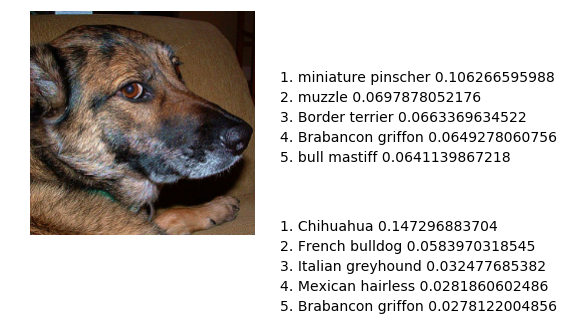

(1, 1000)


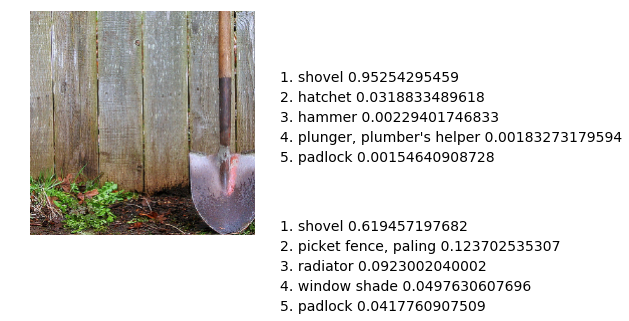

(1, 1000)


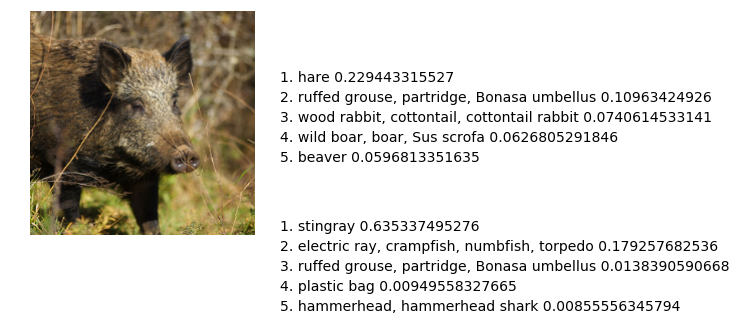

(1, 1000)


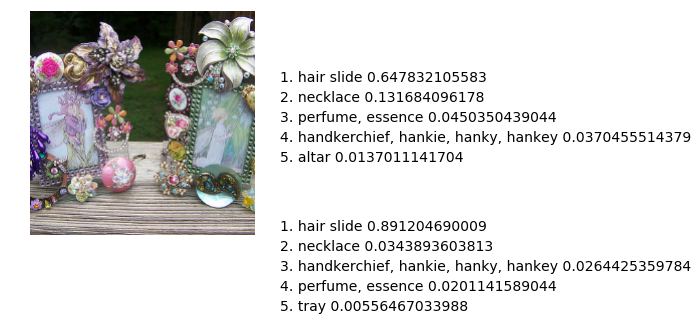

(1, 1000)


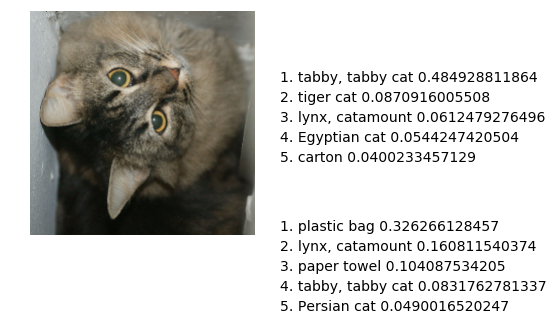

In [23]:
%matplotlib inline

cls = FastGradient(num_images = 1,input_dim=(3,224,224), eps=0.007, 
               loss='softmax')
for url in image_urls:
    try:
        rawim, im = prep_image(url)
        prob = np.array(lasagne.layers.get_output(net['prob'], im, deterministic=True).eval())
        top5 = np.argsort(prob[0])[-1:-6:-1]
        print prob.shape

        plt.figure()
        plt.imshow(rawim.astype('uint8'))
        plt.axis('off')
        for n, label in enumerate(top5):
            plt.text(250, 70 + n * 20, '{}. {} {}'.format(n+1, CLASSES[label],prob[0][label]), fontsize=14)

        
        newim = rawim.transpose(2,0,1)
        final = cls.adExample(newim,np.array([10.0]),model['param values'])
        
        prob = np.array(lasagne.layers.get_output(net['prob'], final, deterministic=True).eval())
        top5 = np.argsort(prob[0])[-1:-6:-1]

        for n, label in enumerate(top5):
            plt.text(250, 220 + n * 20, '{}. {} {}'.format(n+1, CLASSES[label],prob[0][label]), fontsize=14)

        plt.show()
    except IOError:
        print('bad url: ' + url)
        